# Predicting Temperatures using Recurrent Neural Networks

This notebook provides you with a complete code example that uses different kinds of recurrent neural networks to predict the temperature in the Jena Climate Dataset.

## Downloading the Jena Climate Dataset

This dataset contains timeseries recorded at the weather station of the Max Planck Institute for Biogeochemistry in Jena, Germany. It’s made up of 14 different quantities recorded every 10 minutes over several years, from January 1st 2009 to December 31st 2016.

Download the Jena Climante Dataset ...

... and load it.

In [1]:
import pandas as pd

filename = "jena_climate_2009_2016.csv"
dataframe = pd.read_csv(filename, index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()

print(dataframe.head())

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
01.01.2009 00:10:00          3.33          3.11          0.22       1.94   
01.01.2009 00:20:00          3.23          3.02          0.21       1.89   
01.01.2009 00:30:00          3.21          3.01          0.20       1.88   
01.01.2009 00:40:00          3.26          3.07          0.19       1.92   
01.01.2009 00:50:00      

### Visualizing the Data

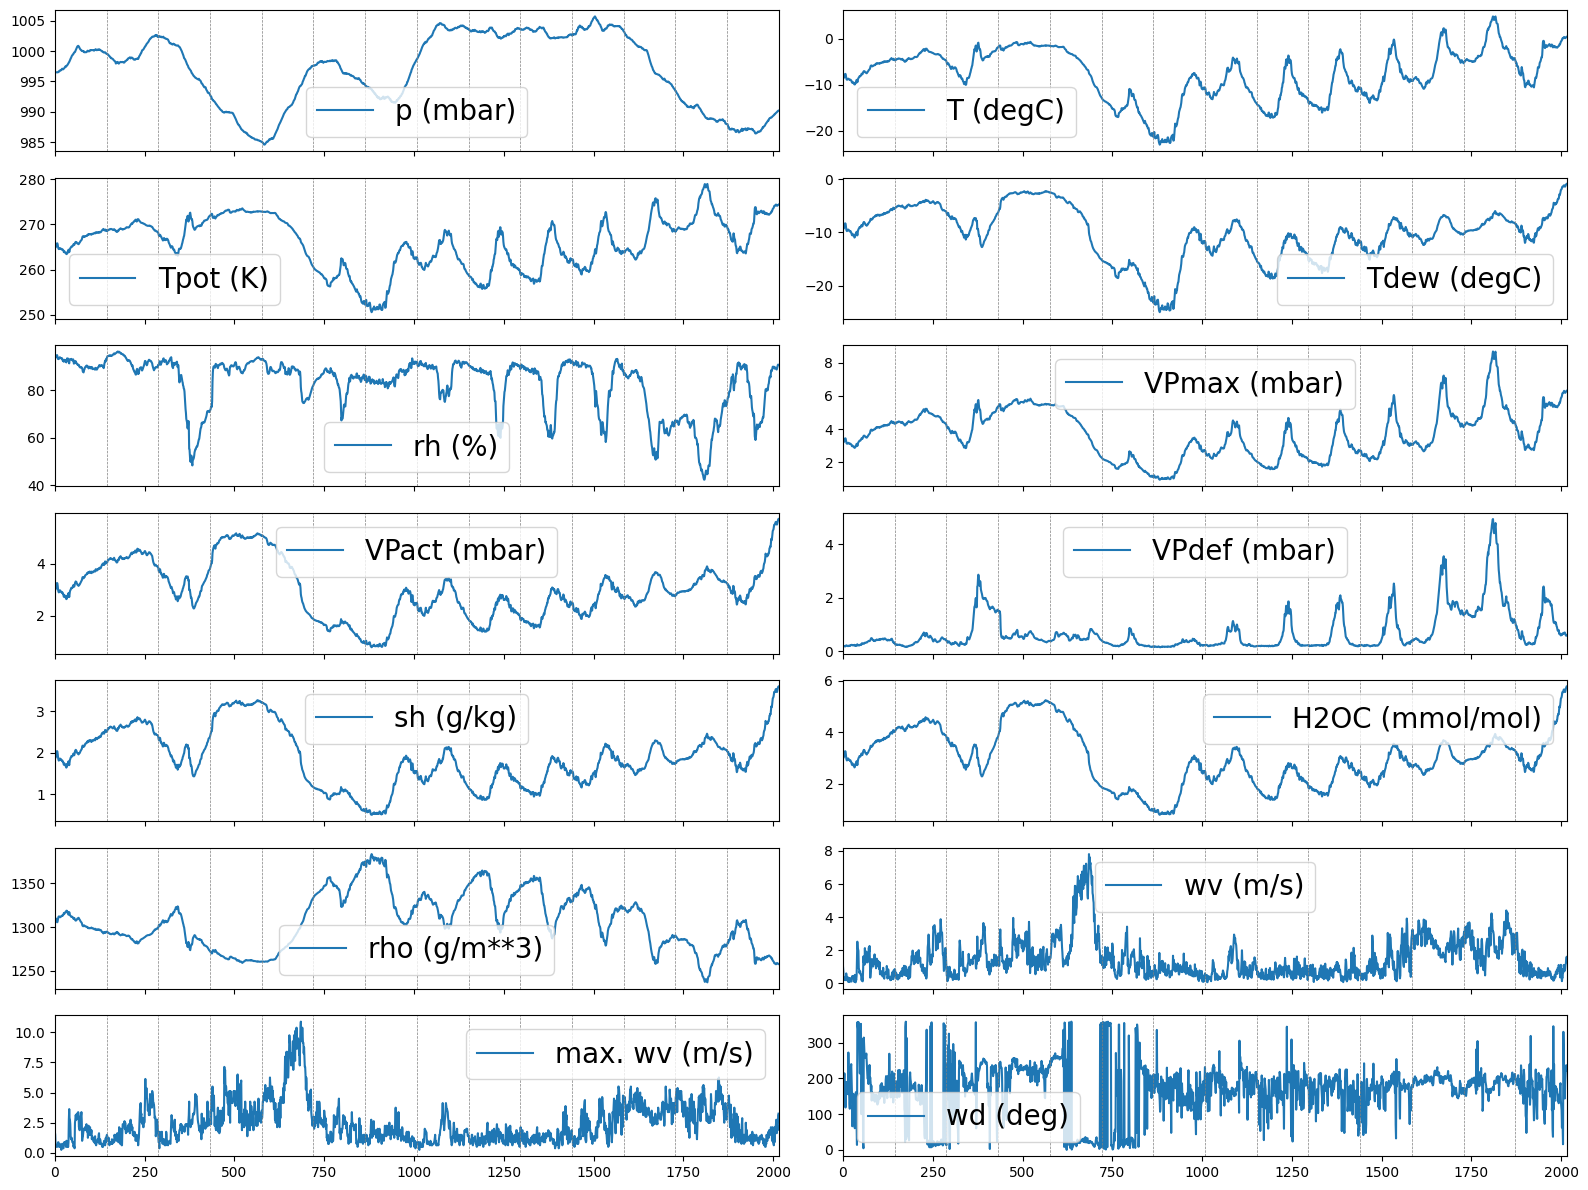

In [20]:
import matplotlib.pyplot as plt
import numpy as np

start = 0
daily_samples = 144
days = 14
end = start + daily_samples * days

fig, axes = plt.subplots(7, 2, figsize=(16, 12), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(start, end), data[start:end, i], label=header[i])
    ax.legend(fontsize=20), ax.set_xlim(start, end)
    ax.tick_params(axis="both", which="major", labelsize=14)
    
    for day in range(1, days):
        ax.axvline(x=start + daily_samples * day,
        color="gray", linestyle="--", linewidth=0.5)
        
plt.tight_layout()
plt.show()

### Preprocessing the Data

Reshape the data in a format ready to train a recurrent neural network ...

In [3]:
n_samples = data.shape[0]
n_features = data.shape[1]
past_seq = 2 * daily_samples
lag = 72
temp_idx = 1 # Temperature (Celsius) index.

inputs, targets = [], []
for i in np.random.permutation(range(0, n_samples - past_seq - lag, 
                                     daily_samples)):
    inputs.append(data[i:i + past_seq, :])
    targets.append(data[i + past_seq + lag:i + past_seq + lag + 1, temp_idx])
inputs, targets = np.asarray(inputs), np.asarray(targets)

print(f"Inputs Shape: {inputs.shape}")
print(f"Targets Shape: {targets.shape}")

Inputs Shape: (2918, 288, 14)
Targets Shape: (2918, 1)


... splitting the data ...

In [4]:
import deeptrack as dt

sources = dt.sources.Source(inputs=inputs, targets=targets)
train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

... standardize the data ...

In [5]:
import torch

train_mean = np.mean([src["inputs"] for src in train_sources], axis=(0, 1))
train_std = np.std([src["inputs"] for src in train_sources], axis=(0, 1))

inputs_pipeline = (dt.Value(sources.inputs - train_mean) / train_std
                   >> dt.pytorch.ToTensor(dtype=torch.float))
targets_pipeline = (dt.Value(sources.targets - train_mean[temp_idx])
                    / train_std[temp_idx])

... and define the data loaders.

In [6]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline, 
                                   inputs=train_sources)
val_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline, 
                                 inputs=val_sources)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Implementing a Common-Sense Benchmark

In [7]:
temperature = data[:, temp_idx]
benchmark_celsius = np.mean(np.abs(
    temperature[daily_samples + lag :: daily_samples] 
    - temperature[lag : - (daily_samples - lag) : daily_samples]
))
benchmark = benchmark_celsius / (train_std[temp_idx])

print(f"Benchmark Celsius: {benchmark_celsius}")
print(f"Normalized Benchmark: {benchmark}")

Benchmark Celsius: 2.664549503254539
Normalized Benchmark: 0.3164902952066465


## Determining on Which Device to Perform the Computations

In [8]:
def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [9]:
device = get_device()

print(device)

mps


## Implementing a Simple Recurrent Neural Network

Define a recurrent neural network in PyTorch ...

In [10]:
import torch.nn as nn

rnn = nn.RNN(input_size=inputs.shape[2], hidden_size=2, batch_first=True)
fc = nn.Linear(in_features=2, out_features=1)
rnn.to(device), fc.to(device);

... train and validate it ...

In [11]:
criterion = nn.L1Loss() # MAE Loss.
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(fc.parameters()),
                             lr=0.001)
epochs = 100

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = 0.0
    for input, target in train_loader:
        optimizer.zero_grad()
        
        input, target = input.to(device), target.to(device)
        rnn_out, _ = rnn(input) # RNN layer.
        rnn_out = rnn_out[:, -1, :] # Last output of sequence.
        output = fc(rnn_out) # Linear layer.

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch {epoch} Training Loss: {train_losses[-1]:.4f}")
    
    val_loss = 0.0
    with torch.no_grad():
        for input, target in val_loader:
            input, target = input.to(device), target.to(device)
            rnn_out, _ = rnn(input)
            rnn_out = rnn_out[:, -1, :]
            output = fc(rnn_out)
            
            loss = criterion(output, target)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch} Validation Loss: {val_losses[-1]:.4f}")

Epoch 0 Training Loss: 0.9331
Epoch 0 Validation Loss: 0.8363
Epoch 1 Training Loss: 0.7484
Epoch 1 Validation Loss: 0.6950
Epoch 2 Training Loss: 0.6251
Epoch 2 Validation Loss: 0.6145
Epoch 3 Training Loss: 0.5518
Epoch 3 Validation Loss: 0.5644
Epoch 4 Training Loss: 0.5099
Epoch 4 Validation Loss: 0.5308
Epoch 5 Training Loss: 0.4842
Epoch 5 Validation Loss: 0.5083
Epoch 6 Training Loss: 0.4658
Epoch 6 Validation Loss: 0.4921
Epoch 7 Training Loss: 0.4519
Epoch 7 Validation Loss: 0.4790
Epoch 8 Training Loss: 0.4409
Epoch 8 Validation Loss: 0.4686
Epoch 9 Training Loss: 0.4321
Epoch 9 Validation Loss: 0.4619
Epoch 10 Training Loss: 0.4247
Epoch 10 Validation Loss: 0.4542
Epoch 11 Training Loss: 0.4183
Epoch 11 Validation Loss: 0.4480
Epoch 12 Training Loss: 0.4129
Epoch 12 Validation Loss: 0.4424
Epoch 13 Training Loss: 0.4083
Epoch 13 Validation Loss: 0.4373
Epoch 14 Training Loss: 0.4050
Epoch 14 Validation Loss: 0.4341
Epoch 15 Training Loss: 0.4021
Epoch 15 Validation Loss: 0.4

... and plot the training and validation losses.

In [12]:
def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], ":k", label="Benchmark")
    plt.xlabel("Epoch"), plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

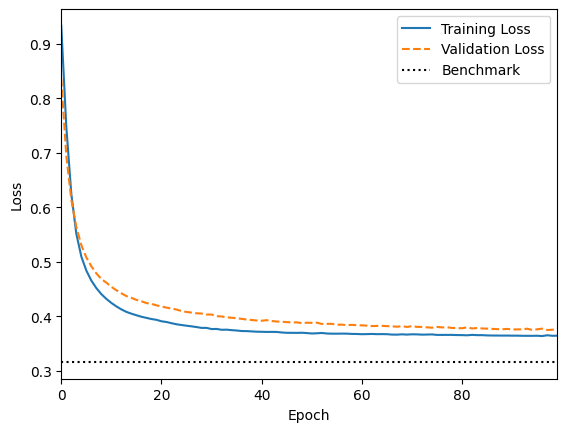

In [13]:
plot_training(epochs, train_losses, val_losses, benchmark)

## Implementing the Recurrent Neural Network in a More Compact Form with Deeplay

Define a recurrent neural network in deeplay ...

In [14]:
import deeplay as dl

rnn_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[2],
    out_features=1,
    rnn_type="RNN",
)
rnn_simple = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.001)).create()

... and train it.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ RecurrentModel   │     39 │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 39                                                                                               
Non-trainable params: 0                                                                                            
Total params: 39                                                                                                   
Total estimated model params size (MB): 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

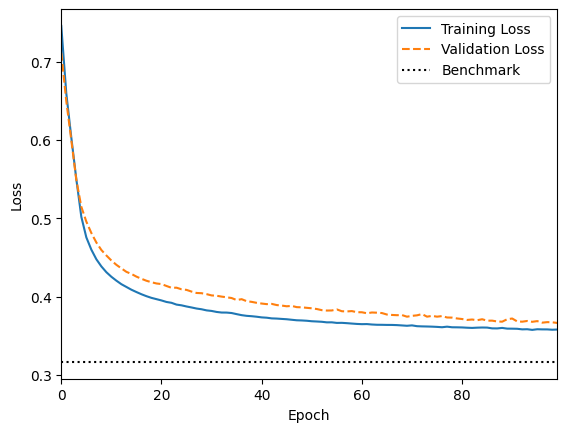

In [15]:
trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(rnn_simple, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Stacking Multiple Recurrent Layers

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ RecurrentModel   │  1.6 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.6 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.6 K                                                                                                
Total estimated model params size (MB): 0

Output()

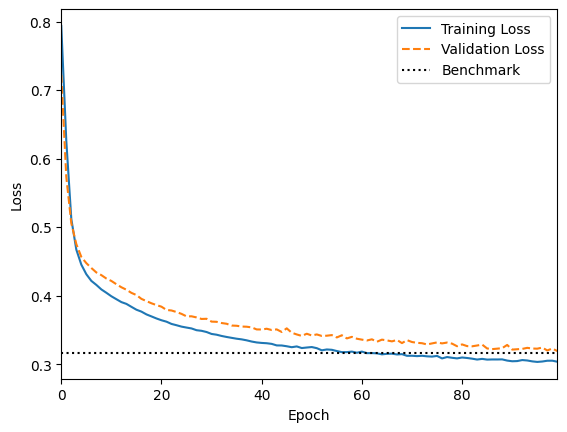

In [16]:
rnn_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[16, 16, 16],
    out_features=1,
    rnn_type="RNN",
)
rnn_stacked = dl.Regressor(rnn_dl, optimizer=dl.Adam(lr=0.0001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(rnn_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Using Gated Recurrent Units

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ RecurrentModel   │  1.4 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 K                                                                                                
Total estimated model params size (MB): 0

Output()

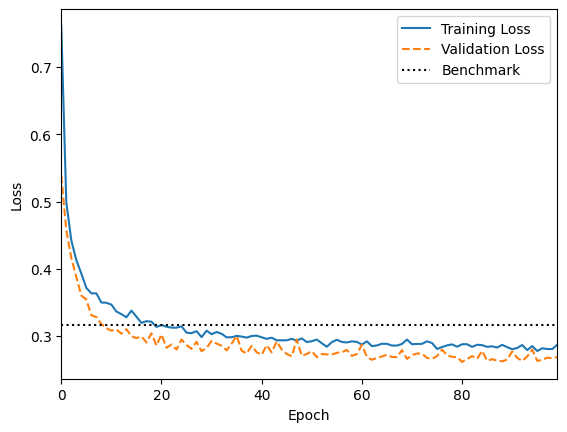

In [17]:
gru_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[8, 8, 8],
    out_features=1,
    rnn_type="GRU",
    dropout=0.2,
)
gru_stacked = dl.Regressor(gru_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(gru_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

## Using Long Short-Term Memory Networks

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ RecurrentModel   │  1.9 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.9 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.9 K                                                                                                
Total estimated model params size (MB): 0

Output()

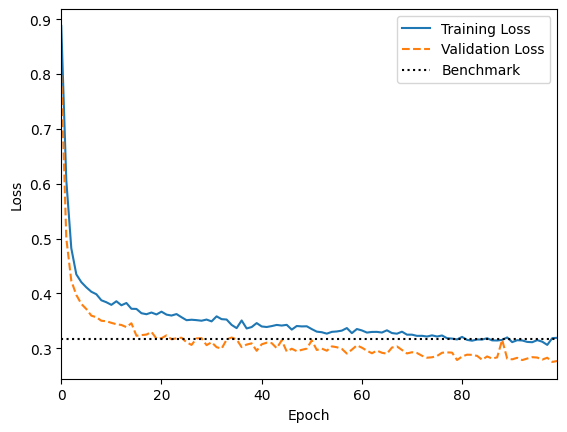

In [18]:
lstm_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[8, 8, 8],
    out_features=1,
    rnn_type="LSTM",
    dropout=0.3,
)
lstm_stacked = dl.Regressor(lstm_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(lstm_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)